In [1]:
import gymnasium as gym
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical

from typing import List, Dict
from statistics import mean

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'

/home/viniciusandreossi/anaconda3/envs/cleanrl/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Resolvendo o ambiente Lunar Lander com Reinforce

<img src="media/lunar_lander.gif" width="200">

Informações importantes para a modelagem do ambiente como um Processo de Decisão de Markov (MDP):

### Espaço de ações

O espaço de ações é discreto e contém os inteiros do intervalo {0, 3}. Uma ação deve indicar a direção de um movimento:
* 0: Não fazer nada
* 1: Ativar motor esquerdo
* 2: Ativar motor principal
* 3: Ativar motor direito

### Espaço de estados

O vetor de estado possui oito elementos: coordenadas x & y, velocidades x & y, ângulo, velocidade de rotação e duas variáveis booleanas que indicam se as pernas da nave estão ou não tocando o chão. 

### Recompensas

A cada passo temporal, a recompensa:

* é aumentada/diminuída se a nave se aproximar/distanciar da plataforma de pouso.
* é aumentada/diminuída se a nave se movimentar mais devagar/rápido.
* é diminuída quanto mais a nave estiver inclinada.
* é aumentada em 10 pontos para cada perna da nave que estiver tocando o chão.
* é diminuída em 0.03 pontos para cada frame em que um motor lateral estiver ativo.
* é diminuída em 0.3 pontos para cada frame em que o motor principal estiver ativo.

No final do episódio, uma recompensa adicional de -100 ou +100 é atribuída caso a a nave colida ou pouse com segurança.

Caso a pontuação final seja maior que 200, o episódio é considerado como solução.


## Criando os modelos

O Reinforce é um algoritmo de gradiente de política, sendo assim a rede neural representa a própria política e é utilizada para calcular a probabilidade de cada ação para um estado (e não o valor de cada ação como em métodos de valor).

In [2]:
class PolicyNet(nn.Module):
    def __init__(self, layer_sizes: List[int] = [64, 64], n_actions=4):
        super().__init__()

        # construindo a rede neural
        layers = []
        input_size = 8
        for n_neurons in layer_sizes:
            layers.append(nn.Linear(input_size, n_neurons))
            layers.append(nn.ReLU())
            input_size = n_neurons
        layers.append(nn.Linear(input_size, n_actions))
        layers.append(nn.Softmax(dim=-1))
        self.nn = nn.Sequential(*layers)

    def forward(self, x):
        x = self.nn(x)
        return x

In [ ]:
class ValueNet(nn.Module):
    def __init__(self, layer_sizes: List[int] = [64, 64]):
        super().__init__()

        # construindo a rede neural
        layers = []
        input_size = 8
        for n_neurons in layer_sizes:
            layers.append(nn.Linear(input_size, n_neurons))
            layers.append(nn.ReLU())
            input_size = n_neurons
        layers.append(nn.Linear(input_size, 1))
        self.nn = nn.Sequential(*layers)

    def forward(self, x):
        x = self.nn(x)
        return x

## Amostrando ações a partir de rede neural de política

Uma das vantagens de substituir a política por uma rede neural é que a política ótima aprendida é intrinsicamente estocástica, sendo que políticas determinísticas são um caso limite em que uma ação tem uma probabilidade infinitamente maior que as outras. Além disso, o fato da política ser naturalmente estocástica faz com que o modelo explore naturalmente durante o aprendizado. 

O Reinforce utiliza o logarítmo da probabilidade da ação escolhida para o cálculo da função de loss, portanto guardar na memória esse valor calculado durante a inferência torna o algoritmo mais eficiente.

In [3]:
def get_action(policy: nn.Module, state):
    probs = policy(torch.tensor([state]).to(DEVICE))
    m = Categorical(probs)
    action = m.sample()
    return action.item(), m.log_prob(action)

## Escolhendo um baseline

A função de loss do Reinforce permite que uma função qualquer que dependa apenas do estado seja subtraída do retorno esperado para o passo. Essa função é chamada de _baseline_ e o valor estimado do estado é uma escolha comum para esse papel que faz com que a variância das atualizações dos pesos diminua sem alterar o valor médio. Essa propriedade leva a uma maior estabilidade durante o treinamento.

Assim como no Q-Learning, a função do valor estimado pode ser aprendida por regressão através de uma rede neural.

## Treinamento das redes neurais 

O Reinforce é um algoritmo de Monte-Carlo e _on-policy_, então ele envolve a amostragem de uma trajetória inteira para dar um passo de aprendizado. Por trajetória define-se toda a sequência de passos desde um estado inicial até um estado final. Após amostrar uma trajetória, calcula-se o retorno observado para cada passo da trajetória seguindo a fórmula a seguir:

$$G_t = \sum_{k=t+1}^T \gamma^{k-t-1}R_k$$

e a diferença entre o retorno observado e o retorno esperado (sem calcular os gradientes):

$$\delta = G_t - \hat{v}(s; \theta)$$

e, depois, para cada passo, atualiza-se os pesos da política ($w$) e da função de valor ($\theta$) seguindo as regras a seguir:

$$w \leftarrow w + \alpha_w \delta \nabla \hat{v}(s;w)$$
$$\theta \leftarrow \theta + \alpha_\theta \gamma^t \delta \nabla \ln{\pi(A_t|s; \theta)}$$

onde $A_t$ é a ação realizada no passo $t$.

In [5]:
def update(
    actor: PolicyNet,
    critic: ValueNet,
    logprob, 
    reward,
    state,
    next_state,
    is_terminal,
    actor_optimizer: torch.optim.Optimizer, 
    critic_optimizer: torch.optim.Optimizer,
    gamma,
    step):

    expected_value = critic(torch.tensor([state]).to(DEVICE))
    with torch.no_grad():
        delta = reward + gamma * critic(torch.tensor([next_state]).to(DEVICE)) * (1 - int(is_terminal)) - expected_value

    # critic loss
    critic_loss = delta * expected_value
    critic_optimizer.zero_grad()
    critic_loss.backward()
    critic_optimizer.step()

    # actor loss
    actor_loss = gamma ** step * delta * logprob
    actor_optimizer.zero_grad()
    actor_loss.backward()
    actor_optimizer.step()
    
    return actor, critic, actor_loss.item(), critic_loss.item()

## Avaliação de desempenho

In [11]:
def evaluate(metrics: Dict, show_result=False):
    rewards = torch.tensor(metrics['episode_rewards'])
    plt.figure(1)
    plt.clf
    plt.title('Total reward of each episode')
    plt.xlabel('Episode')
    plt.ylabel('Total reward')
    plt.grid()
    plt.plot(rewards)

    # Take 100 episode averages and plot them too
    if metrics['avg_reward'] is not None: 
        x = range(49, 49 + len(metrics['avg_reward']))
        plt.plot(x, metrics['avg_reward'].numpy())
    plt.pause(0.001)  # pause a bit so that plots are updated

    # plotting losses
    fig, ax1 = plt.subplots()
    plt.clf

    ax2 = ax1.twinx()
    ax1.plot(x, metrics['avg_policy_loss_on_ep'], 'green')
    ax2.plot(x, metrics['avg_value_loss_on_ep'], 'blue')

    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Policy loss', color='green')
    ax2.set_ylabel('Value loss', color='blue')

    plt.title('Losses')
    plt.grid()
    plt.show()
    
    plt.pause(0.001)

    if not show_result:
        display.display(plt.gcf())
        display.clear_output(wait=True)
    else:
        display.display(plt.gcf())


## Loop de treinamento

No loop de treinamento repetiremos o processo de amostrar uma trajetória e atualizar os pesos das redes de política e valor com base na trajetória observada.

In [12]:
def train(
        env: gym.Env, 
        policy: PolicyNet,
        value: ValueNet,
        total_steps=10_000,
        ep_max_steps=1000,
        gamma=0.99,
        policy_lr=5e-4,
        baseline_lr=5e-4,
        verbose=False):
    
    policy_optimizer = torch.optim.Adam(policy.parameters(), lr=policy_lr)
    baseline_optimizer = torch.optim.Adam(value.parameters(), lr=baseline_lr)
    
    metrics = {
        'episode_rewards': [],
        'avg_reward': None,
        'avg_policy_loss_on_ep': [],
        'avg_value_loss_on_ep': [],
    }
    episode_step = 0
    truncated = False

    state, _ = env.reset()
    ep_step = 0
    ep_reward = 0
    policy_loss_on_ep = []
    value_loss_on_ep = []

    for global_step in range(total_steps):
        action, logprob = get_action(policy, state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        ep_reward += reward
    
        # update policy
        policy, value, policy_loss, value_loss = update(policy, value, logprob, reward, state, next_state, \
                                                           terminated, policy_optimizer, baseline_optimizer, gamma, ep_step)
        policy_loss_on_ep.append(policy_loss)
        value_loss_on_ep.append(value_loss)
        state = next_state
            
        if terminated or truncated or ep_step >= ep_max_steps:
            # logging        
            if verbose:
                metrics['episode_rewards'].append(ep_reward)
                if len(metrics['episode_rewards']) > 50:
                    metrics['avg_reward'] = torch.tensor(metrics['episode_rewards']).float().unfold(0, 50, 1).mean(1)
                    print(f'avg reward: {metrics["avg_reward"][-1]}')

                metrics['avg_policy_loss_on_ep'].append(mean(policy_loss_on_ep))
                metrics['avg_value_loss_on_ep'].append(mean(value_loss_on_ep))

                print(f'current step: {global_step}')

                evaluate(metrics)
            
            # reset episode
            state, _ = env.reset()
            ep_step = 0
            ep_reward = 0
            policy_loss_on_ep = []
            value_loss_on_ep = []
        

    evaluate(metrics, show_result=True)
    return policy

## Treinando

Está tudo configurado, portanto agora podemos rodar o algoritmo!

avg reward: -17.36025619506836


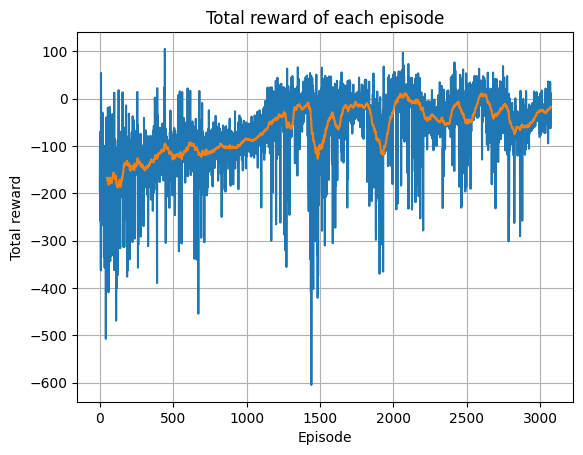

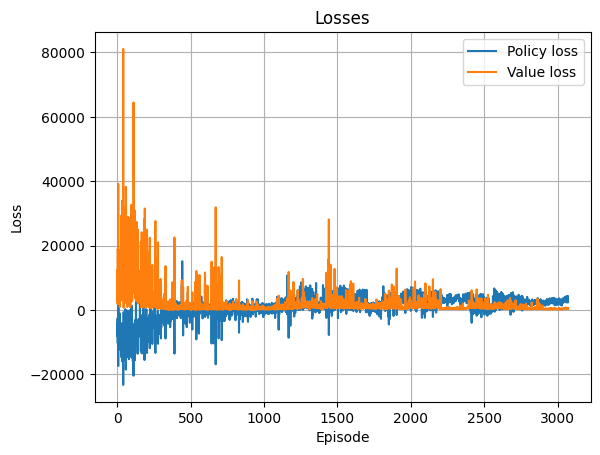

<Figure size 640x480 with 0 Axes>

In [14]:
lunar_lander = gym.make(
    "LunarLander-v2",
    continuous = False,
    gravity = -10.0,
    enable_wind = False,
    wind_power = 15.0,
    turbulence_power = 1.5,
)
policy_net = PolicyNet().to(DEVICE)
baseline = ValueNet().to(DEVICE)
trained_policy_net = train(lunar_lander, policy_net, baseline, policy_lr=1e-3, verbose=True)

avg reward: -49.255584716796875


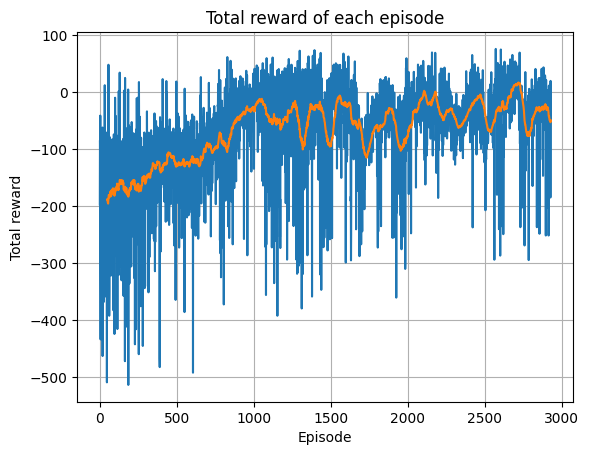

<Figure size 640x480 with 0 Axes>

In [20]:
lunar_lander = gym.make(
    "LunarLander-v2",
    continuous = False,
    gravity = -10.0,
    enable_wind = False,
    wind_power = 15.0,
    turbulence_power = 1.5,
)
policy_net = PolicyNet()
baseline = ValueBaseline()
trained_policy_net = train(lunar_lander, policy_net, baseline, verbose=True)

## Testando o agente

A função abaixo rodará um episódio com o agente já treinado.

In [ ]:
def test(env: gym.Env, 
          q_net,
          n_episodes=1,
          verbose=False
          ):
    
    total_rewards = []
    for episode in range(n_episodes):
        state, _ = env.reset()
        total_reward = 0
        done = False
        
        while not done:
            action = get_action(q_net, state, 0)
            state, reward, terminated, truncated, _ = env.step(action)
            total_reward += reward

            done = terminated or truncated

        if verbose:
            print(f"Episode {episode} - Total reward: {total_reward}")
            
        total_rewards.append(total_reward)

    env.close()
    total_reward = torch.tensor(total_rewards, dtype=torch.float32)
    return torch.mean(total_reward)

test(gym.make('LunarLander-v2', render_mode="human"), trained_q_net)

tensor(261.2986)

## Exercício - ambientes não-determinísticos

O Lunar Lander, assim como o Cliff Walking, também possui uma versão com vento aleatório que faz com que o ambiente se torne não determinístico. Tente encontrar uma taxa de aprendizado que permita solucionar essa versão do ambiente! Ela é maior ou menor que a taxa utilizada anteriormente? O efeito de um ambiente não determinístico sobre a taxa de aprendizado é análogo ao observado no algoritmo tabular?

In [ ]:
nd_lunar_lander = gym.make('LunarLander-v2', enable_wind=True, render_mode="human")
nd_q_net = Qnet()
trained_nd_q_net = train(nd_lunar_lander, nd_q_net, total_steps=450_000, epsilon_decay=100_000, learning_rate=5e-4, replay_buffer_size=2 ** 20, batch_size=128, verbose=True)

NameError: name 'Qnet' is not defined